<img src = "images/Logo.png" width = 220, align = "left">

<h1 align=center><font size = 6><span style="color:blue">Case Study: Advertising</span></font></h1>
<h2 align=center><font size = 5>Lab Exercise 3.2</font></h2>
<h3 align=center><font size = 4><b>Advanced Machine Learning Made Easy<br></b><small>From Theory to Practice with NumPy and scikit-learn<br><i>Volume 1: Generalized Linear Models</i></font></h3>

## Introduction

The Advertising dataset consists of sales of that product in 200 different markets, along with advertising budgets for the product in each of those markets for three different media: TV, radio, and newspaper. Our task is to find a linear model that could help in creating an association between advertising and sales. Then we can use this model to predict sales based on the three media budgets. Thus, as a data scientist, our task is to suggest, based on this data and the obtained (linear) model, a marketing plan for next year that would result in higher product sales. That is, we can instruct our client to adjust advertising budgets, thereby indirectly increasing sales while keeping our advertising budget the same.<br>
**Note**: *The following exercise is based on the book "An Introduction to Statistical Learning - with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. Both the book and the dataset can be found at http://www-bcf.usc.edu/~gareth/ISL/*


### Table of contents
1. [Reading the data](#ReadingData)
2. [Analyzing the data](#AnalyzingData)
3. [Scatter plot of the data](#ScatterPlot)
4. [Fitting a multiple linear regression model](#LinearModelFit)
5. [Feature selection](#FeatureSelection)
6. [Confidence and prediction intervals, confidence regions](#ConfidenceRegions)
7. [Removing the additive assumption](#AdditiveAssumptionRemoval)

## 1. Reading the data <a name="ReadingData"></a>

As a first step, we import the required libraries.

In [1]:
import numpy as np
from numpy.linalg import matrix_rank, inv, svd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import os
%matplotlib inline

Then we read the dataset directly from the homepage of the book "*An Introduction to Statistical Learning - with Applications in R*" by Gareth James, Daniela Witten, Trevor Hastie, and Robert Tibshirani. Let's print out the dataset.

**Note**: *In case "urlopen error" is thrown due to moved webpage, comment out the first line and uncomment the line below.*

In [2]:
data = pd.read_csv('http://faculty.marshall.usc.edu/gareth-james/ISL/Advertising.csv', index_col=0) # Reading from web page
#data = pd.read_csv(os.path.join('data','Advertising.csv')) # Uncomment this line in case the above line trows an error
data

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9
...,...,...,...,...
196,38.2,3.7,13.8,7.6
197,94.2,4.9,8.1,9.7
198,177.0,9.3,6.4,12.8
199,283.6,42.0,66.2,25.5


As we can see, the advertising budgets for *TV*, *radio*, *newspaper*,in thousands of dollars, are the independent variables, $x_1,x_2,x_3$, while *sales*sales, in thousands of units, is the dependent variable $y$. There are $N=200$ observations.

## 2. Analyzing the data <a name="AnalyzingData"></a>

Before creating the linear model, we should check that there is no invalid entry in the dataset (-inf and +inf is also considered NaN, e.i., not a number). You might also create short statistics for each variable to check if there is no unusual entry (e.g., minimum or maximum value far away from the mean).  

In [3]:
pd.options.mode.use_inf_as_na = True
print(data.isnull().values.any())
data.describe()

False


,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


You may also create the boxplot to check the distribution of the data.

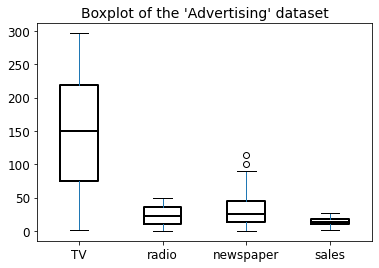

In [4]:
boxprops = dict(linestyle='-', linewidth=2, color='k')
medianprops = dict(linestyle='-', linewidth=2, color='k')

data.boxplot(column=['TV','radio','newspaper','sales'],fontsize=12,grid=False,boxprops=boxprops, medianprops=medianprops)
plt.title("Boxplot of the 'Advertising' dataset",fontsize=14)
plt.show()

Only the newspaper variable shows two outliers.

Extract the input and output values from the pandas dataframe into matrix $\mathbf{\dot X}$ and vector $\mathbf{y}$. Also, extract the number of observations and the number of features available in the dataset.

In [5]:
X=np.array(data[["TV","radio","newspaper"]])
y_=np.array(data["sales"])[:,np.newaxis]
N,D=X.shape
print("Number of observations =",N)
print("Number of features =", D)

Number of observations = 200
Number of features = 3


Now, let's insert a column at the beginning of $\mathbf X$ corresponding to the constant term (intercept) to obtain the design matrix $\mathbf{\dot X}$.

In [6]:
Xdot=np.insert(X,0,np.ones(N),axis=1)

#### Check for collinearity 

First, check the rank of the design matrix.

In [7]:
print("Rank of the design matrix is:",matrix_rank(Xdot))

Rank of the design matrix is: 4


The rank of the design matrix is equal to the number of coefficients, including the intercept.<br>
Next, calculate the condition number. 

In [8]:
from numpy.linalg import eigh
eigval,eigvect=eigh(Xdot.T@Xdot)
print("Eigenvalues of the product matrix:")
print(eigval[:,np.newaxis])
print("Condition number =",np.sqrt(eigval.max()/eigval.min()))

Eigenvalues of the product matrix:
[[2.91966344e+01]
 [3.78300718e+04]
 [1.58827294e+05]
 [6.02783643e+06]]
Condition number = 454.37490123426164


You can also use the *cond* method of NumPy library to calculate the condition number.

In [9]:
from numpy.linalg import cond
print(cond(Xdot))

454.3749012342605


The condition number is not very big which does not suggest any collinearity issue.<br>
Finally, calculate the variance inflation factor (VIF).

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
print("VIF for TV =",variance_inflation_factor(Xdot,1))
print("VIF for radio =",variance_inflation_factor(Xdot,2))
print("VIF for newspaper =",variance_inflation_factor(Xdot,3))

VIF for TV = 1.0046107849396502
VIF for radio = 1.1449519171055353
VIF for newspaper = 1.1451873787239288


As can be observed, the VIF values are close to 1, which indicates no collinearity among predictors.

## 2. Scatter plot of the data <a name="ScatterPlot"></a>

Let's first make a separate scatter plot of the *sales* as a function of *TV*, *radio*, and *newspaper*. Also, plot the estimated regression lines for each scatter plot and annotate each plot with the Pearson correlation coefficient.

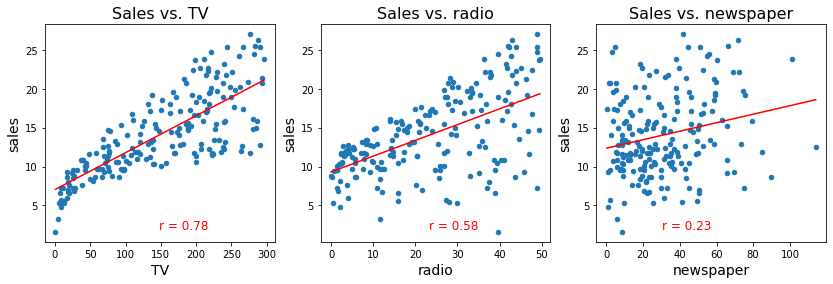

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
xvarlist=['TV','radio','newspaper']
linregr=LinearRegression()
for i in range(D):
    ax[i].scatter(X[:,i],y_,s=20)
    x_=X[:,i].reshape(-1,1)
    linregr.fit(x_,y_)
    ax[i].plot([x_.min(),x_.max()],linregr.predict(np.array([[x_.min()],[x_.max()]])),c='r')
    ax[i].set_xlabel(list(data.columns.values)[i],fontsize=14)
    ax[i].set_ylabel(list(data.columns.values)[D],fontsize=14)
    ax[i].set_title('Sales vs. '+xvarlist[i],fontsize=16)
    ax[i].annotate('r = '+'%.2f'%np.corrcoef(np.append(X,y_,axis=1), rowvar=False)[:,-1][i],\
                   xy=(X.mean(axis=0)[i],2),color='red',fontsize=12)
plt.show()

The above plot displays sales, in thousands of units, as a function of TV, radio, and newspaper advertising expenditure, in thousands of dollars, for 200 different markets. We can observe, that each red line (as the estimated regression line) represents a simple linear regression model that can be used to predict sales using TV, radio, and newspaper, respectively.

You should also observe that the Pearson correlation coefficient is quite high for TV and radio and still significant for the newspaper.

The above figures are a good starting point in analyzing multi-dimensional input data. But you may also want to check whether there is any correlation between the independent variables. So you may also want to create a separate scatter plot between the pair of independent variables.
This can be done in a condensed format using the so-called matrix of scatter plots which can be easily created with the *seeborn* library.

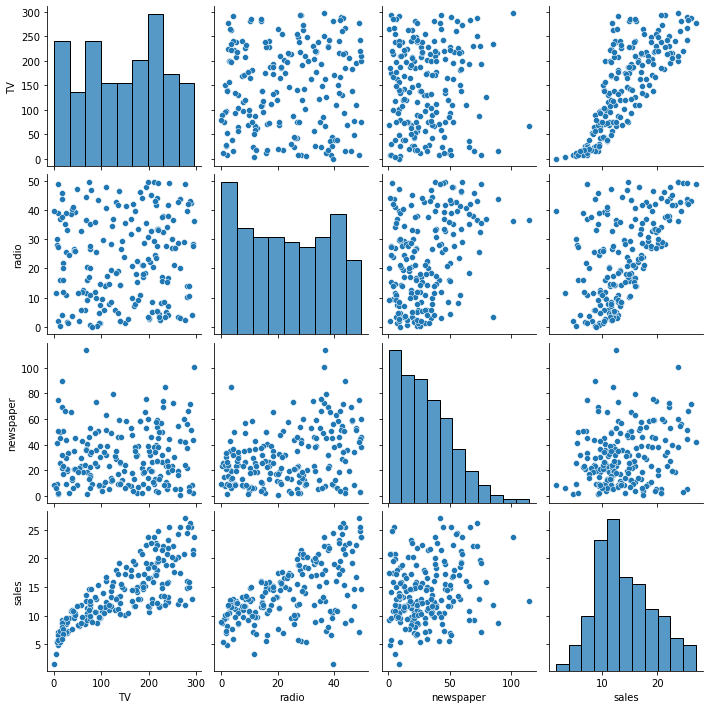

In [12]:
import seaborn as sns
sns.pairplot(data)
plt.show()

*Pandas* library also has *scatter_matrix* method for plotting the scatter plot matrix.

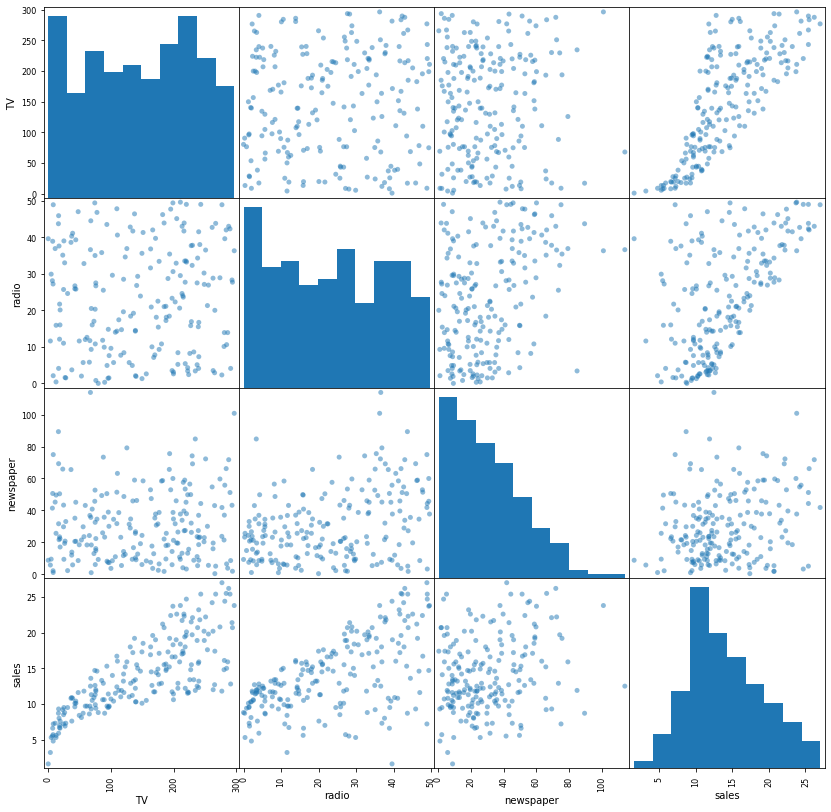

In [13]:
pd.plotting.scatter_matrix(data,figsize=(14,14),s=100)
plt.show()

The matrix of the scatter plot is symmetric, and the scatter plots of the last row (or last column) represents the scatter plot of the *sales* as a function of *TV*, *radio*, and *newspaper* shown before. We have also the scatter plot between the input variables, so it can be checked visually if there is any correlation between them. The diagonal figures show the histograms of the variables (inputs, respective output).
 
Checking the scatter plot between *radio* and *TV* (first plot in the second row), respective between *newspaper* and *TV* or *newspaper* and *radio* (first two plots in the third row) shows no any evidence of correlation among independent variables.

We can also create an OLS summary of the individual regressions.

In [14]:
from scipy import stats
conflevel=95
alpha=1-conflevel/100
df=N-2
tscore=abs(stats.t.ppf(alpha/2, df))
pd.options.display.float_format = '{:,.3f}'.format

def OLSresults(x_,y_):
    linregr=LinearRegression()
    linregr.fit(x_,y_)
    r_=y_-linregr.predict(x_)
    MSE=r_.T@r_/(N-2)
    s_w=float(np.squeeze(np.sqrt(MSE/np.sum((x_-x_.mean())**2))))
    s_b=float(np.squeeze(s_w*np.sqrt(x_.T@x_/N)))
    table=pd.DataFrame(columns=["Input","Coefficient","Std. error","t-statistic","p-value","[0.025","0.975]"])
    t_stat=linregr.intercept_[0]/s_b
    pval = stats.t.sf(np.abs(t_stat),df)*2
    LCL=linregr.intercept_[0]-tscore*s_b
    UCL=linregr.intercept_[0]+tscore*s_b
    table=table.append({"Input":"Intercept","Coefficient":linregr.intercept_[0],"Std. error":s_b,"t-statistic":t_stat,\
                        "p-value":pval,"[0.025":LCL,"0.975]":UCL},ignore_index=True)
    t_stat=linregr.coef_[0][0]/s_w
    pval = stats.t.sf(np.abs(t_stat),df)*2
    LCL=linregr.coef_[0][0]-tscore*s_w
    UCL=linregr.coef_[0][0]+tscore*s_w
    table=table.append({"Input":list(data.columns.values)[i],"Coefficient":linregr.coef_[0][0],"Std. error":s_w,\
                        "t-statistic":t_stat,"p-value":pval,"[0.025":LCL,"0.975]":UCL},ignore_index=True)
    return table,MSE,linregr.score(x_,y_),r_

R=[]
print("============================================================================")
for i in range(D):
    x_=X[:,i].reshape(-1,1)
    print(OLSresults(x_,y_)[0])
    print('----------------------------------------------------------------------------')
    print("RSE=%f, R-squared=%f\n"%(float(np.sqrt(OLSresults(x_,y_)[1])),OLSresults(x_,y_)[2]))
    print("============================================================================")
    R.append(OLSresults(x_,y_)[3])

R=np.array(R).squeeze().T # Store the residual vectors

       Input  Coefficient  Std. error  t-statistic  p-value  [0.025  0.975]
0  Intercept        7.033       0.458       15.360    0.000   6.130   7.935
1         TV        0.048       0.003       17.668    0.000   0.042   0.053
----------------------------------------------------------------------------
RSE=3.258656, R-squared=0.611875

       Input  Coefficient  Std. error  t-statistic  p-value  [0.025  0.975]
0  Intercept        9.312       0.563       16.542    0.000   8.202  10.422
1      radio        0.202       0.020        9.921    0.000   0.162   0.243
----------------------------------------------------------------------------
RSE=4.274944, R-squared=0.332032

       Input  Coefficient  Std. error  t-statistic  p-value  [0.025  0.975]
0  Intercept       12.351       0.621       19.876    0.000  11.126  13.577
1  newspaper        0.055       0.017        3.300    0.001   0.022   0.087
----------------------------------------------------------------------------
RSE=5.092480, R-s

The above OLS results show the simple linear regression models of each media when the other two media are not considered. As we can observe, all 3 media has a significantly nonzero coefficient. 

Let's check the residual plot for each regression.

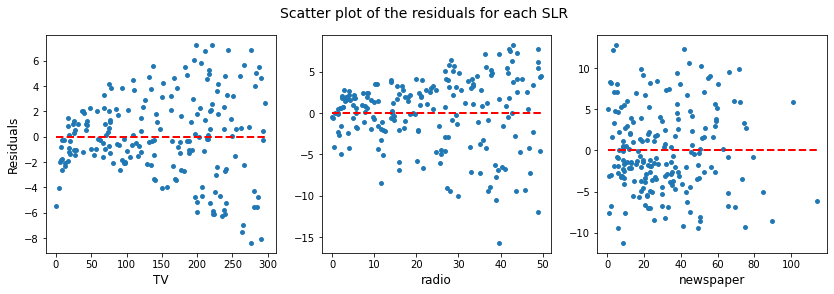

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].scatter(X[:,0],R[:,0],s=15)
ax[0].plot([X[:,0].min(),X[:,0].max()],[0,0],'--r',lw=2)
ax[1].scatter(X[:,1],R[:,1],s=15)
ax[1].plot([X[:,1].min(),X[:,1].max()],[0,0],'--r',lw=2)
ax[2].scatter(X[:,2],R[:,2],s=15)
ax[2].plot([X[:,2].min(),X[:,2].max()],[0,0],'--r',lw=2)
ax[0].set_xlabel('TV',fontsize=12)
ax[1].set_xlabel('radio',fontsize=12)
ax[2].set_xlabel('newspaper',fontsize=12)
ax[0].set_ylabel('Residuals',fontsize=12)
fig.suptitle("Scatter plot of the residuals for each SLR", fontsize=14)
plt.show()

From the residual plot, you might suspect the presence of heteroskedasticity for *TV* and *radio*.

Let's create the OLS using the *statsmodels* library and check for homoskedasticity using the Goldfeld-Quandt test.

In [16]:
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
results = ols(formula = 'sales ~ TV', data=data).fit()
print(results.summary(title='OLS Results for TV vs. sales'))
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(results.resid, results.model.exog)
print("\nGoldfeld-Quandt test:\n",lzip(name, test))
print("RMSE =",np.sqrt(results.mse_resid))

                         OLS Results for TV vs. sales                         
Dep. Variable:                  sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Mon, 30 Nov 2020   Prob (F-statistic):           1.47e-42
Time:                        21:11:20   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.0

In [17]:
results = ols(formula = 'sales ~ radio', data=data).fit()
print(results.summary(title='OLS Results for radio vs. sales'))
test = sms.het_goldfeldquandt(results.resid, results.model.exog)
print("\nGoldfeld-Quandt test:\n",lzip(name, test))
print("RMSE =",np.sqrt(results.mse_resid))

                       OLS Results for radio vs. sales                        
Dep. Variable:                  sales   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     98.42
Date:                Mon, 30 Nov 2020   Prob (F-statistic):           4.35e-19
Time:                        21:11:20   Log-Likelihood:                -573.34
No. Observations:                 200   AIC:                             1151.
Df Residuals:                     198   BIC:                             1157.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.3116      0.563     16.542      0.0

In [18]:
results = ols(formula = 'sales ~ newspaper', data=data).fit()
print(results.summary(title='OLS Results for newspaper vs. sales'))
test = sms.het_goldfeldquandt(results.resid, results.model.exog)
print("\nGoldfeld-Quandt test:\n",lzip(name, test))
print("RMSE =",np.sqrt(results.mse_resid))

                     OLS Results for newspaper vs. sales                      
Dep. Variable:                  sales   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     10.89
Date:                Mon, 30 Nov 2020   Prob (F-statistic):            0.00115
Time:                        21:11:20   Log-Likelihood:                -608.34
No. Observations:                 200   AIC:                             1221.
Df Residuals:                     198   BIC:                             1227.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3514      0.621     19.876      0.0

Based on the Goldfeld-Quandt test, we can conclude that the residuals have constant variance.<br>
Next, create the normal probability plots for the residuals for each regression to check the normality of the residuals.

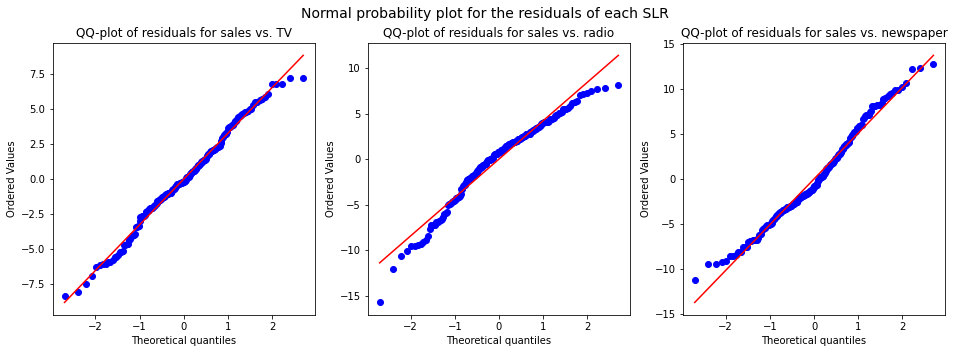

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
stats.probplot(np.ravel(R[:,0]), plot=ax[0])
stats.probplot(np.ravel(R[:,1]), plot=ax[1])
stats.probplot(np.ravel(R[:,2]), plot=ax[2])
ax[0].set_title('QQ-plot of residuals for sales vs. TV')
ax[1].set_title('QQ-plot of residuals for sales vs. radio')
ax[2].set_title('QQ-plot of residuals for sales vs. newspaper')
fig.suptitle("Normal probability plot for the residuals of each SLR", fontsize=14)
plt.show()

From the normal probability plots, we can conclude that the residuals of each simple linear regression have an approximately normal distribution. Thus, we can rely on standard errors and confidence intervals created with OLS. So far so good.

However, the approach of fitting a separate simple linear regression model for each predictor is not entirely satisfactory because each of the media budgets is associated with a separate regression equation and ignores the other two media in forming estimates for the regression coefficients. If the media budgets are correlated with each other, then this can lead to very misleading estimates of the individual media effects on sales. You may also observe that the R-squared value is quite low for *radio vs. sales*, and especially very low for *newspaper vs. sales*.

## 4. Fitting a multiple linear regression model <a name="LinearModelFit"></a>

For the above reasons, we should rather fit a multiple linear regression model to see if it has any extra value. Using the same instance of the *scikit-learn* class, we fit a linear model considering all 3 media types.

**Note:** *You should pass the input matrix without the intercept, and not the design matrix to the fit method.*

In [20]:
linregr.fit(X,y_)
print("Intercept =",linregr.intercept_[0])
for i,media in zip(range(3),["TV coef. =","Radio coef. =","Newspaper coef. ="]):
    print(media,linregr.coef_[0][i])
print("R-squared =",linregr.score(X,y_))
print("R-squared adjusted =",1-(1-linregr.score(X,y_))*(N-1)/(N-D-1))
MSE=float((y_-linregr.predict(X)).T@(y_-linregr.predict(X))/(N-2))
print("RMSE =",np.sqrt(MSE))

Intercept = 2.9388893694594067
TV coef. = 0.04576464545539761
Radio coef. = 0.18853001691820462
Newspaper coef. = -0.0010374930424762972
R-squared = 0.8972106381789522
R-squared adjusted = 0.8956373316204668
RMSE = 1.6769760888385674


We can see that the R-squared value is increased significantly, being almost 0.9. Thus, 90%  of the sales variability is explained by our model. Moreover, now the root mean square error (RMSE) dropped significantly.

As we can observe, the coefficients of *TV* and *radio* have been slightly decreased compared to what we obtained from the individual single linear regression models. More interestingly, the coefficient for the newspaper became almost zero.

Using the *statsmodel* library, we can create further statistics for this multiple linear regression model.

In [21]:
results = ols(formula = 'sales ~ TV + radio + newspaper', data=data).fit()
print(results.summary())
test = sms.het_goldfeldquandt(results.resid, results.model.exog)
print("\nGoldfeld-Quandt test:\n",lzip(name, test))
print("RMSE =",np.sqrt(results.mse_resid))

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Mon, 30 Nov 2020   Prob (F-statistic):           1.58e-96
Time:                        21:11:21   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.0

The F-test shows that our multiple linear regression model is significantly better than the average model (with all slope coefficients set to zero). That is, at least one of the regression coefficient is significantly different from zero.

Although the exact value for the coefficient of the newspaper is not zero, the null hypothesis for t-statistic cannot be rejected (i.e., $w_3=0$), and the confidence interval not only includes the zero value, but the center of the confidence interval is near zero. This illustrates that the simple and multiple regression coefficients can be quite different.

Let's also print out the residual plot. Because there are three input variables, not all of them can be used on the horizontal axis when creating a 2D residual plot. In the case of multiple linear regression, the only way to have a 2D residual plot is to have the linear combination of the input variables on the horizontal axis. This is exactly the predicted value, $\hat y$. 

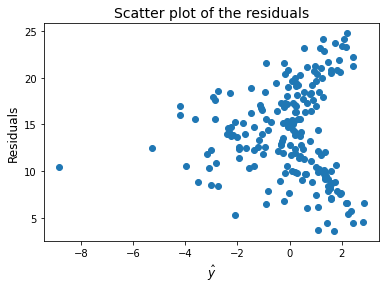

In [22]:
plt.scatter(results.resid, results.predict())
plt.title('Scatter plot of the residuals',fontsize=14)
plt.xlabel('$\hat y$',fontsize=12)
plt.ylabel('Residuals',fontsize=12)
plt.show()

From the residual plot, you might suspect the presence of heteroskedasticity, but the Goldfeld-Quandt test shows otherwise. So we can rely on the standard errors and confidence intervals.

Finally, check the normality of the residuals graphically.

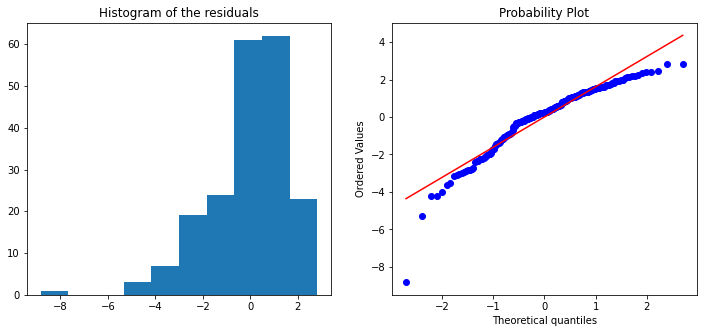

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].hist(results.resid)
ax[0].set_title('Histogram of the residuals',fontsize=12)
stats.probplot(results.resid,plot=ax[1])
plt.show()

There seem to be one outlier (see the value close to -8 on the histogram), but otherwise the residual plot slightly resembles to a normal distribution. So we can rely on the standard errors and confidence intervals.

## 5. Feature selection <a name="FeatureSelection"></a>

According to the t-test in the previous section, we ended up that we cannot reject the null hypothesis that the regression coefficient of the newspaper is zero. So let's select only the *TV* and *radio* as features in our next model. <br>
But before doing so, let's check the correlation matrix of the three predictor variables and response variables to see the degree of correlation between them.

In [24]:
pd.DataFrame(data=np.corrcoef(np.append(X,y_,axis=1), rowvar=False)\
                ,index=['TV','radio','newspaper','sales'],columns=['TV','radio','newspaper','sales'])

,TV,radio,newspaper,sales
TV,1.000,0.055,0.057,0.782
radio,0.055,1.000,0.354,0.576
newspaper,0.057,0.354,1.000,0.228
sales,0.782,0.576,0.228,1.000


Notice that the correlation between radio and newspaper is greater than 0.35. This reveals a tendency to spend more on newspaper advertising in markets where more is spent on radio advertising or vice verso. However, the multiple linear regression model suggests that the budget spent on the newspaper advartising does not increase our sales.

Notice that the correlation between radio and newspaper is greater than 0.35. This reveals a tendency to spend more on newspaper advertising in markets where more is spent on radio advertising, or vice verso. However, the multiple linear regression model suggests that the budget spent on newspaper advertising does not increase our sales.

Even though there is some positive correlation between the radio and newspaper budget, the variance inflation factors do not show any sign of multicollinearity between the independent variables, as we already found out during data analysis. 

Let's try to fit a linear regression model using only the *TV* and *radio* as predictors.

In [25]:
linregr.fit(X[:,0:2],y_)
print("Intercept =",linregr.intercept_[0])
for i,media in zip(range(2),["TV coef. =","Radio coef. ="]):
    print(media,linregr.coef_[0][i])
print("R-squared =",linregr.score(X[:,0:2],y_))
print("R-squared adjusted =",1-(1-linregr.score(X[:,0:2],y_))*(N-1)/(N-D-1))
MSE=float((y_-linregr.predict(X[:,0:2])).T@(y_-linregr.predict(X[:,0:2]))/(N-2))
print("RMSE =",np.sqrt(MSE))

Intercept = 2.9210999124051362
TV coef. = 0.04575481510107616
Radio coef. = 0.18799422662030923
R-squared = 0.8971942610828956
R-squared adjusted = 0.8956207038545726
RMSE = 1.6771096771017617


More statistics can be obtained with *statmodels* library.

In [26]:
results = ols(formula = 'sales ~ TV + radio', data=data).fit()
print(results.summary())
test = sms.het_goldfeldquandt(results.resid, results.model.exog)
print("\nGoldfeld-Quandt test:\n",lzip(name, test))
sigma=np.sqrt(results.mse_resid)
print("RMSE =",np.sqrt(results.mse_resid))

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     859.6
Date:                Mon, 30 Nov 2020   Prob (F-statistic):           4.83e-98
Time:                        21:11:22   Log-Likelihood:                -386.20
No. Observations:                 200   AIC:                             778.4
Df Residuals:                     197   BIC:                             788.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9211      0.294      9.919      0.0

As can be observed, with only two predictors (*TV* and *radio*), we obtain the same R-squared value as with three, and the F-statistic becomes even slightly greater than before.

In conclusion, we can state that the sales are predicted very well with only two predictors (advertising expenditure on TV and radio). We can state that a unit change in the advertising expenditure of TV will provide an increase of 0.0458 unit increase in sales while keeping expenditure on radio advertising fix, and a unit change in the advertising expenditure of radio will provide an increase of 0.1880 unit increase in sales while keeping expenditure on TV advertising fix. That also means that advertising on radio is more efficient, because one thousand dollar additional budget spent only on radio advertising will end up in 188 additional unit sales in contrast to only 46 additional unit sales if that additional budget is spent on TV advertising.

Thus, we can use our multiple linear regression model for predicting the sales based on advertising expenditure on different media, but we should keep in mind the uncertainty of our prediction. 

Although the Goldfeld-Quandt test does not reject the homoskedasticity, the p-value is quite close to the 0.05 threshold. Let's check the normality of the residuals using histogram and QQ-plot. 

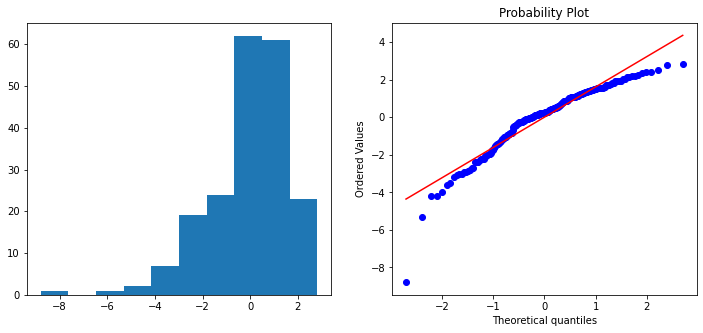

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].hist(results.resid)
stats.probplot(results.resid,plot=ax[1])
plt.show()

Again, we can see one outlier around -8 (see on the left of the histogram above). Let's check what happens if we remove this observation and create a regression with the remaining dataset.

In [28]:
data1=data.drop(index=131)
results = ols(formula = 'sales ~ TV + radio', data=data1).fit()
print(results.summary())
test = sms.het_goldfeldquandt(results.resid, results.model.exog)
print("\nGoldfeld-Quandt test:\n",lzip(name, test))
sigma=np.sqrt(results.mse_resid)
print("RMSE =",np.sqrt(results.mse_resid))

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     982.2
Date:                Mon, 30 Nov 2020   Prob (F-statistic):          7.18e-103
Time:                        21:11:23   Log-Likelihood:                -369.43
No. Observations:                 199   AIC:                             744.9
Df Residuals:                     196   BIC:                             754.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0188      0.274     11.022      0.0

Both the R-squared value and the F-statistic slightly increased while the regression coefficients for TV and radio slightly altered (coefficient for TV slightly decreased and for radio slightly increased). However, the regression coefficients are not modified significantly, thus, the outlier should not be considered an influential point.

What is more important that the Goldfeld-Quandt test now provides more evidence against heteroskedasticity, and the Skew gets closer to 0 while the Kurtosis gets closer to 3. The latter two can be considered as signs for the correctness of the normality assumption. As a conclusion, we can rely on the standard error and confidence interval shown by the OLS results. This is even true for the OLS based on the whole dataset as the outlier is not an influential point.

## 5. Confidence and prediction intervals, confidence regions <a name="ConfidenceRegions"></a>

#### Confidence and prediction intervals

Confidence and prediction intervals can be created in a similar way as we did for the simple linear regression. The only difference is, that because there are more than one independent variable, the confidence and prediction intervals cannot be shown graphically, except when we have only two variables (like in this case with 'TV" and 'Radio'). Because both the confidence and prediction interval of the estimated conditional mean depends on the Mahalanobis distance of the input from the center of the input data, let's calculate first the center of the input and the inverse of the sample covariance matrix.

In [29]:
mu_=X[:,0:2].mean(axis=0)[:,np.newaxis]
Sigma=1/(N-1)*(X[:,0:-1]-mu_.T).T@(X[:,0:-1]-mu_.T)
Sigma_1=inv(Sigma)

Then draw a scatter plot of the observations together with the estimated regression plane in 3D, respective the boundary of the prediction interval, which represents hyperparabolic planes. The confidence interval for the conditional mean is not drawn to keep the graph readable.

**Note:** *The 3D plot will open in a new window where you can rotate the plot to see from a different angle. The execution of code will not continue until you close the window.*

In [30]:
%matplotlib qt

w0=linregr.intercept_
w_=linregr.coef_.T
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0], X[:,1], y_, c='b', alpha=1)
# Creating the meshgrid for x (TV), y (radio) and calculating the value of z (sales)
xx, yy = np.meshgrid(np.arange(0,300,5), np.arange(0,50,5))
y_mean = w0+w_[0,0]*xx+w_[1,0]*yy
# Plotting the estimated conditional mean surface
zz = y_mean
surf = ax.plot_surface(xx, yy, zz, cmap=cm.Blues, linewidth=0, antialiased=False, alpha=0.7)
# Calculating the Mahalanobis distance for the meshgrid
imax,jmax=xx.shape
d_M2=np.array([[float(np.array([xx[i,j]-mu_[0,0],yy[i,j]-mu_[1,0]])[:,np.newaxis].T@Sigma_1@\
                      np.array([xx[i,j]-mu_[0,0],yy[i,j]-mu_[1,0]])[:,np.newaxis]) for j in range(jmax)] for i in range(imax)])
# Plotting the boundary surface for the prediction interval
zz = y_mean+tscore*np.sqrt(MSE)*np.sqrt(1+1/N+1/(N-1)*d_M2)
surf = ax.plot_surface(xx, yy, zz, cmap=cm.Reds, linewidth=0, antialiased=False, alpha=0.7)
zz = y_mean-tscore*np.sqrt(MSE)*np.sqrt(1+1/N+1/(N-1)*d_M2)
surf = ax.plot_surface(xx, yy, zz, cmap=cm.Reds, linewidth=0, antialiased=False, alpha=0.7)
ax.set_xlabel('TV',fontsize=12)
ax.set_ylabel('radio',fontsize=12)
ax.set_zlabel('Sales',fontsize=12)
plt.title('Estimated regression plane with prediction interval',fontsize=14)
plt.show(block=True)

To understand the confidence and prediction intervals let's take an example.
For example, given that 10000 USD is spent on TV advertising and 90000 USD is spent on radio advertising in each market, the estimated mean of the average sale is:

In [31]:
linregr.fit(X[:,0:2],y_)
w_=list(linregr.intercept_)
w_.extend(list(linregr.coef_[0]))
w_=np.array(w_)[:,np.newaxis]
xnew_=np.array([[1],[10],[90]])
yhatnew=float(xnew_.T@w_)
print("Estimated average sale:",yhatnew*1000)

Estimated average sale: 20298.12845924373


The 95% confidence interval is:

In [32]:
alpha=0.05
tscore=abs(stats.t.ppf(alpha/2, df))
[1000*float(yhatnew-tscore*sigma*np.sqrt(xnew_.T@inv(Xdot[:,:-1].T@Xdot[:,:-1])@xnew_)),\
1000*float(yhatnew+tscore*sigma*np.sqrt(xnew_.T@inv(Xdot[:,:-1].T@Xdot[:,:-1])@xnew_))]

[19215.93931597803, 21380.317602509433]

and the 95% prediction interval is:

In [33]:
[1000*float(yhatnew-tscore*sigma*np.sqrt(1+xnew_.T@inv(Xdot[:,:-1].T@Xdot[:,:-1])@xnew_)),\
1000*float(yhatnew+tscore*sigma*np.sqrt(1+xnew_.T@inv(Xdot[:,:-1].T@Xdot[:,:-1])@xnew_))]

[17035.77357872728, 23560.483339760183]

#### Confidence regions

We already created the individual confidence intervals for the regression coefficients. Now, let's create a joint confidence region as a rectangle from the individual confidence intervals, respective also create the confidence rectangle using the Bonferroni correction method. We should also create the ellipse of the confidence region.

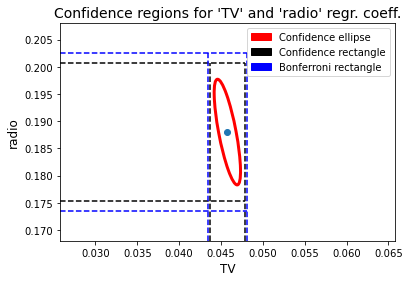

In [34]:
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
%matplotlib inline

xlim=0.02
ylim=0.02

ax= plt.subplot(111)
w_=linregr.coef_.T

#Plot the center
ax.scatter(w_[0],w_[1])

# Plot the 95% confidence ellipse
U,Diag,V=svd(X[:,0:2].T@X[:,0:2]/(3*MSE*stats.f.ppf(1-0.05,2,198)))
width,height=np.sqrt(1/Diag)
theta=np.degrees(np.arctan2(V[0,1],V[0,0]))
ellipsoid=Ellipse(w_.ravel(), width, height, theta, edgecolor='r', fc='None',lw=3)
ax.add_patch(ellipsoid)

# Plot the confidence rectangle
tscore=abs(stats.t.ppf(alpha/2, df))
w1min,w2min=w_-tscore*np.sqrt(np.diag(MSE*inv(X[:,0:2].T@X[:,0:2])))[:,np.newaxis]
w1max,w2max=w_+tscore*np.sqrt(np.diag(MSE*inv(X[:,0:2].T@X[:,0:2])))[:,np.newaxis]
ax.plot([w1min,w1min],[w_[1]-ylim,w2max],'k--')
ax.plot([w1max,w1max],[w_[1]-ylim,w2max],'k--')
ax.plot([w_[0]-xlim,w1max],[w2min,w2min],'k--')
ax.plot([w_[0]-xlim,w1max],[w2max,w2max],'k--')

# Plot the Bonferroni confidence rectangle
tscore=abs(stats.t.ppf(alpha/4, df))
w1min,w2min=w_-tscore*np.sqrt(np.diag(MSE*inv(X[:,0:2].T@X[:,0:2])))[:,np.newaxis]
w1max,w2max=w_+tscore*np.sqrt(np.diag(MSE*inv(X[:,0:2].T@X[:,0:2])))[:,np.newaxis]
ax.plot([w1min,w1min],[w_[1]-ylim,w2max],'b--')
ax.plot([w1max,w1max],[w_[1]-ylim,w2max],'b--')
ax.plot([w_[0]-xlim,w1max],[w2min,w2min],'b--')
ax.plot([w_[0]-xlim,w1max],[w2max,w2max],'b--')

red_patch = mpatches.Patch(color='red', label='Confidence ellipse')
black_patch = mpatches.Patch(color='black', label='Confidence rectangle')
blue_patch = mpatches.Patch(color='blue', label='Bonferroni rectangle')
plt.legend(handles=[red_patch,black_patch,blue_patch])

plt.xlim(w_[0]-xlim, w_[0]+xlim)
plt.ylim(w_[1]-ylim, w_[1]+ylim)
plt.xlabel('TV',fontsize=12)
plt.ylabel('radio',fontsize=12)
plt.title("Confidence regions for 'TV' and 'radio' regr. coeff.",fontsize=14)
plt.show()

As we can observe, the Bonferroni correction makes the individual confidence intervals wider, while the confidence ellipse is much narrower than what the naive confidence rectangle provides.

## 6. Removing the additive assumption <a name="AdditiveAssumptionRemoval"></a>

**Note:** *This part is related to $\textbf{Removing Beyond the OLS Assumptions}$ of the book. You may check this part of the lab exercise only after reading the relavand section of the book (3.6.2 Removing the Additive Assumption).*

So far so good! You created a model that explains around 90% percent of the variability of the sales. So you can go to your boss to present your work. Your linear model has the form of

$\hat y=w_0 + w_1 x_1 + w_2 x_2$<br>

where $x_1$ represents the *TV* and $x_2$ the *radio* independent variable.

However, your boss has some doubts about the validity of your model. Especially that your model suggests, it is better to spend the budget on radio advertising than on TV, which seems to be unrealistic. If you want to maximize your sales with a given fix advertising budget, you should advertise on the radio only. Now that you got the feedback from your boss, you have to make your homework again and create a model, which provides a more realistic result.

Previously, we concluded that both TV and radio seem to be associated with sales. The linear models that formed the basis for this conclusion assumed that the effect on sales of increasing one advertising medium is independent of the amount spent on the other media. For example, the average effect on sales of a one-unit increase in TV is always $w_1$, regardless of the amount spent on radio. But this simple model may be incorrect. Suppose that spending money on radio advertising increases the effectiveness of TV advertising. In marketing, this is known as a synergy effect, and in statistics, it is referred to as an interaction effect. Let's consider the linear model:

$\hat y^\star=w_0^\star + w_1^\star x_1 + w_2^\star x_2 + w_3^\star x_1 x_2 $

and denote with $x_3=x_1 x_2$. Let's create this interaction effect as a third predictor.

In [35]:
data['TVxRadio'] = data['TV']*data['radio']
data

,TV,radio,newspaper,sales,TVxRadio
1,230.100,37.800,69.200,22.100,"8,697.780"
2,44.500,39.300,45.100,10.400,"1,748.850"
3,17.200,45.900,69.300,9.300,789.480
4,151.500,41.300,58.500,18.500,"6,256.950"
5,180.800,10.800,58.400,12.900,"1,952.640"
...,...,...,...,...,...
196,38.200,3.700,13.800,7.600,141.340
197,94.200,4.900,8.100,9.700,461.580
198,177.000,9.300,6.400,12.800,"1,646.100"
199,283.600,42.000,66.200,25.500,"11,911.200"


Then create the OLS summary with *statsmodels* library.

In [36]:
model = ols(formula = 'sales ~ TV + radio + TVxRadio', data=data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1963.
Date:                Mon, 30 Nov 2020   Prob (F-statistic):          6.68e-146
Time:                        21:13:11   Log-Likelihood:                -270.14
No. Observations:                 200   AIC:                             548.3
Df Residuals:                     196   BIC:                             561.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.7502      0.248     27.233      0.0

The results strongly suggest that the model that includes the interaction term is superior to the model that contains only the main effects. The p-value for the interaction term, *TVxRadio*, is extremely low, indicating that there is strong evidence for the alternative hypothesis of $w_3\neq 0$. Even if this interaction effect has a very low coefficient, the standard error is extremely low. In other words, a true relationship is not additive. The R-squared value is also increased from 89.7% to 96.8%.

You may use the *scikit-learn* library to obtain the same result. You may also find that the RMSE also dropped to 0.94.

In [37]:
X1=data[['TV','radio','TVxRadio']].to_numpy()
N,D=X1.shape
linregr.fit(X1,y_)
print("Intercept =",linregr.intercept_[0])
for i,media in zip(range(3),["TV coef. =","Radio coef. =","TV x Radio coef. ="]):
    print(media,linregr.coef_[0][i])
print("R-squared =",linregr.score(X,y_))
print("R-squared adjusted =",1-(1-linregr.score(X1,y_))*(N-1)/(N-D-1))
MSE=float((y_-linregr.predict(X1)).T@(y_-linregr.predict(X1))/(N-2))
print("RSE =",np.sqrt(MSE))

Intercept = 6.750220203075112
TV coef. = 0.01910107383104333
Radio coef. = 0.028860339899924935
TV x Radio coef. = 0.001086494697989954
R-squared = -0.0420531106967299
R-squared adjusted = 0.9672975480602154
RSE = 0.938738091903456


What is more important than the R-squared value is that the conclusion drawn from your model is different. With only additive assumption, you may suggest that the optimal solution to maximize the sales with a given advertising budget of 100 thousand dollars would be to use only the radio medium. In such a case, your model would predict almost 22 thousand units in sales with that advertising budget. However, with the non-additive assumption, you will get a more realistic result, which suggests that the advertising budget should be split equally between TV and radio. In this case, however, the predicted sales are below 12 thousand units, which is only slightly more than half of what the additive assumption predicted. 

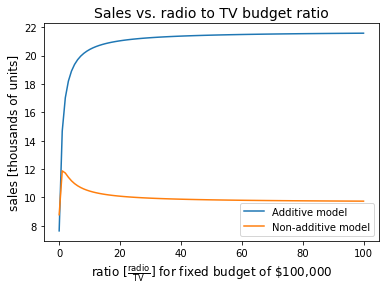

In [38]:
budget=100
linregr.fit(X[:,0:2],y_)
w_=list(linregr.intercept_)
w_.extend(list(linregr.coef_[0]))
w_=np.array(w_)[:,np.newaxis]
ratio_=np.linspace(0.01,100,100)
yhat_=w_[0]+w_[1]*budget/(1+ratio_)+w_[2]*budget*ratio_/(1+ratio_)
plt.plot(ratio_,yhat_,label='Additive model')

linregr.fit(X1,y_)
w_=list(linregr.intercept_)
w_.extend(list(linregr.coef_[0]))
w_=np.array(w_)[:,np.newaxis]
ratio_=np.linspace(0.01,100,100)
yhat_=w_[0]+w_[1]*budget/(1+ratio_)+w_[2]*budget*ratio_/(1+ratio_)+w_[3]*budget**2*ratio_/(1+ratio_)**2
plt.plot(ratio_,yhat_,label='Non-additive model')

plt.title('Sales vs. radio to TV budget ratio', fontsize=14)
plt.xlabel(r'ratio [$\frac{\mathrm{radio}}{\mathrm{TV}}$] for fixed budget of \$100,000',fontsize=12)
plt.ylabel('sales [thousands of units]',fontsize=12)
plt.legend()
plt.show()

You can print out the maximum sales value for the non-additive model.

In [39]:
print('Maximum sales in thousand of units with advertising budget of 100,000$ =',yhat_.max())

Maximum sales in thousand of units with advertising budget of 100,000$ = 11.869092682819455


We can find out the radio to TV advertising expenditure ratio for the non-additive model with maximum sales.

In [40]:
print('Radio to TV advertising expenditure ratio for maximized sales =',np.argmax(yhat_))

Radio to TV advertising expenditure ratio for maximized sales = 1


Wow! Not only your model explains now 97% of the variability of the sales, but more importantly provides more realistic scenario regarding how you should spend the advertising budget to maximize the sales, namely the budget shall be split equally between the two media: radio and TV. There is also a surprise in the outcome, the predicited maximum sales value is much lower, only slightly more than half of what the first model suggested. That is a good example why the R-squared value should not be taken as granted and common sense should be also used.

<img src = "images/AML1-Cover.png" width = 110, align = "left" style="margin:0px 20px">

<span style="color:blue">**Note:**</span> This Jupyter Notebook is accompanying the book: <br> $\qquad$ <b>Advanced Machine Learning Made Easy</b> <br> $\qquad$ From Theory to Practice with NumPy and scikit-learn <br> $\qquad$ <i> Volume 1: Generalized Linear Models</i><br>
by Ferenc Farkas, Ph.D.  

If you find this Notebook useful, please support me by buying the book at [Leanpub](http://leanpub.com/AML1). <br>
Copyright notice: This Jupyter Notebook is made available under the [MIT License](https://opensource.org/licenses/MIT).